# SSD300 Training Tutorial

This tutorial explains how to train an SSD300 on the Pascal VOC datasets. The preset parameters reproduce the training of the original SSD300 "07+12" model. Training SSD512 works simiarly, so there's no extra tutorial for that. The same goes for training on other datasets.

You can find a summary of a full training here to get an impression of what it should look like:
[SSD300 "07+12" training summary](https://github.com/pierluigiferrari/ssd_keras/blob/master/training_summaries/ssd300_pascal_07%2B12_training_summary.md)

In [1]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


## 0. Preliminary note

All places in the code where you need to make any changes are marked `TODO` and explained accordingly. All code cells that don't contain `TODO` markers just need to be executed.

## 1. Set the model configuration parameters

This section sets the configuration parameters for the model definition. The parameters set here are being used both by the `ssd_300()` function that builds the SSD300 model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to run the training. Most of these parameters are needed to define the anchor boxes.

The parameters as set below produce the original SSD300 architecture that was trained on the Pascal VOC datsets, i.e. they are all chosen to correspond exactly to their respective counterparts in the `.prototxt` file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the models were trained. The scaling factors used for the MS COCO datasets are smaller than the scaling factors used for the Pascal VOC datasets. The reason why the list of scaling factors has 7 elements while there are only 6 predictor layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.

As mentioned above, the parameters set below are not only needed to build the model, but are also passed to the `SSDInputEncoder` constructor further down, which is responsible for matching and encoding ground truth boxes and anchor boxes during the training. In order to do that, it needs to know the anchor box parameters.

In [2]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model and load trained VGG-16 weights into it (or trained SSD weights)

If you want to create a new SSD300 model, this is the relevant section for you. If you want to load a previously saved SSD300 model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `ssd_300()` to build the model.
2. It then loads the weights file that is found at `weights_path` into the model. You could load the trained VGG-16 weights or you could load the weights of a trained model. If you want to reproduce the original SSD training, load the pre-trained VGG-16 weights. In any case, you need to set the path to the weights file you want to load on your local machine. Download links to all the trained weights are provided in the [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this repository.
3. Finally, it compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

Normally, the optimizer of choice would be Adam (commented out below), but since the original implementation uses plain SGD with momentum, we'll do the same in order to reproduce the original training. Adam is generally the superior optimizer, so if your goal is not to have everything exactly as in the original training, feel free to switch to Adam. You might need to adjust the learning rate scheduler below slightly in case you use Adam.

Note that the learning rate that is being set here doesn't matter, because further below we'll pass a learning rate scheduler to the training function, which will overwrite any learning rate set here, i.e. what matters are the learning rates that are defined by the learning rate scheduler.

`SSDLoss` is a custom Keras loss function that implements the multi-task that consists of a log loss for classification and a smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper.

In [3]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

weights_path = '/usr/local/data/msmith/uncertainty/ssd_keras/weights/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

W0917 10:48:56.420818 139627547825920 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0917 10:48:56.422572 139627547825920 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0917 10:48:56.460218 139627547825920 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 10:48:56.462652 139627547825920 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

### 2.2 Load a previously created model

If you have previously created and saved a model and would now like to load it, execute the next code cell. The only thing you need to do here is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'path/to/trained/model.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training

The code cells below set up the data generators for the training and validation datasets to train the model. The settings below reproduce the original SSD training on Pascal VOC 2007 `trainval` plus 2012 `trainval` and validation on Pascal VOC 2007 `test`.

The only thing you need to change here are the filepaths to the datasets on your local machine. Note that parsing the labels from the XML annotations files can take a while.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. The first option that `DataGenerator` provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, `DataGenerator` provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images (around 9 GB total for Pascal VOC 2007 `trainval` plus 2012 `trainval` and another 2.6 GB for 2007 `test`). You can later load these HDF5 datasets directly in the constructor.

The original SSD implementation uses a batch size of 32 for the training. In case you run into GPU memory issues, reduce the batch size accordingly. You need at least 7 GB of free GPU memory to train an SSD300 with 20 object classes with a batch size of 32.

The `DataGenerator` itself is fairly generic. I doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the `transformations` and `label_encoder` arguments of the data generator's `generate()` method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

The data augmentation settings defined further down reproduce the data augmentation pipeline of the original SSD training. The training generator receives an object `ssd_data_augmentation`, which is a transformation object that is itself composed of a whole chain of transformations that replicate the data augmentation procedure used to train the original Caffe implementation. The validation generator receives an object `resize`, which simply resizes the input images.

An `SSDInputEncoder` object, `ssd_input_encoder`, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

In order to train the model on a dataset other than Pascal VOC, either choose `DataGenerator`'s appropriate parser method that corresponds to your data format, or, if `DataGenerator` does not provide a suitable parser for your data format, you can write an additional parser and add it. Out of the box, `DataGenerator` can handle datasets that use the Pascal VOC format (use `parse_xml()`), the MS COCO format (use `parse_json()`) and a wide range of CSV formats (use `parse_csv()`).

In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/JPEGImages/'
VOC_2012_images_dir      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/Annotations/'
VOC_2012_annotations_dir      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '/usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

# train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
#                                   resize=False,
#                                   variable_image_size=True,
#                                   verbose=True)

# val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
#                                 resize=False,
#                                 variable_image_size=True,
#                                 verbose=True)

Loading images into memory: 100%|██████████| 4952/4952 [00:58<00:00, 84.92it/s] 


In [5]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## 4. Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 1,000 training steps. The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit.

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes `NaN`. Depending on the optimizer you use, it can happen that the loss becomes `NaN` during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a `NaN` loss when I trained SSD using an Adam optimizer, but I've seen a `NaN` loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.

In [8]:
# Define a learning rate schedule.

# def lr_schedule(epoch):
#     if epoch < 80:
#         return 0.001
#     elif epoch < 100:
#         return 0.0001
#     else:
#         return 0.00001

In [6]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 56:
        return 0.001
    elif epoch < 76:
        return 0.0001
    else:
        return 0.00001

In [7]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_dropout_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_dropout_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## 5. Train

In order to reproduce the training of the "07+12" model mentioned above, at 1,000 training steps per epoch you'd have to train for 120 epochs. That is going to take really long though, so you might not want to do all 120 epochs in one go and instead train only for a few epochs at a time. You can find a summary of a full training [here](https://github.com/pierluigiferrari/ssd_keras/blob/master/training_summaries/ssd300_pascal_07%2B12_training_summary.md).

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. In order for the learning rate scheduler callback above to work properly, `fit_generator()` needs to know which epoch we're in, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. In order for the model checkpoint callback above to work correctly after a kernel restart, set `model_checkpoint.best` to the best validation loss from the previous training. If you don't do this and a new `ModelCheckpoint` object is created after a kernel restart, that object obviously won't know what the last best validation loss was, so it will always save the weights of the first epoch of your new training and record that loss as its new best loss. This isn't super-important, I just wanted to mention it.

In [8]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 801s 801ms/step - loss: 17.2861 - val_loss: 14.9024

Epoch 00001: val_loss improved from inf to 14.90238, saving model to ssd300_dropout_pascal_07+12_epoch-01_loss-17.2822_val_loss-14.9024.h5
Epoch 2/120

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 787s 787ms/step - loss: 15.9882 - val_loss: 14.6417

Epoch 00002: val_loss improved from 14.90238 to 14.64165, saving model to ssd300_dropout_pascal_07+12_epoch-02_loss-15.9922_val_loss-14.6417.h5
Epoch 3/120

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 780s 780ms/step - loss: 15.3293 - val_loss: 13.3943

Epoch 00003: val_loss improved from 14.64165 to 13.39432, saving model to ssd300_dropout_pascal_07+12_epoch-03_loss-15.3203_val_loss-13.3943.h5
Epoch 4/120

Epoch 00004: LearningRateS

Epoch 27/120

Epoch 00027: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 790s 790ms/step - loss: 6.5269 - val_loss: 6.2703

Epoch 00027: val_loss improved from 6.27280 to 6.27032, saving model to ssd300_dropout_pascal_07+12_epoch-27_loss-6.5278_val_loss-6.2703.h5
Epoch 28/120

Epoch 00028: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 771s 771ms/step - loss: 6.4297 - val_loss: 6.1237

Epoch 00028: val_loss improved from 6.27032 to 6.12372, saving model to ssd300_dropout_pascal_07+12_epoch-28_loss-6.4285_val_loss-6.1237.h5
Epoch 29/120

Epoch 00029: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 782s 782ms/step - loss: 6.3469 - val_loss: 6.0743

Epoch 00029: val_loss improved from 6.12372 to 6.07428, saving model to ssd300_dropout_pascal_07+12_epoch-29_loss-6.3473_val_loss-6.0743.h5
Epoch 30/120

Epoch 00030: LearningRateScheduler 

1000/1000 [==============================] - 771s 771ms/step - loss: 5.0056 - val_loss: 4.8780

Epoch 00054: val_loss improved from 4.93892 to 4.87805, saving model to ssd300_dropout_pascal_07+12_epoch-54_loss-5.0050_val_loss-4.8780.h5
Epoch 55/120

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 787s 787ms/step - loss: 4.9738 - val_loss: 4.8714

Epoch 00055: val_loss improved from 4.87805 to 4.87140, saving model to ssd300_dropout_pascal_07+12_epoch-55_loss-4.9745_val_loss-4.8714.h5
Epoch 56/120

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 777s 777ms/step - loss: 4.9334 - val_loss: 4.8846

Epoch 00056: val_loss did not improve from 4.87140
Epoch 57/120

Epoch 00057: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 780s 780ms/step - loss: 4.6813 - val_loss: 4.6566

Epoch 00057: val_loss improved from 4.871

1000/1000 [==============================] - 772s 772ms/step - loss: 4.3967 - val_loss: 4.5202

Epoch 00083: val_loss did not improve from 4.51952
Epoch 84/120

Epoch 00084: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 779s 779ms/step - loss: 4.4007 - val_loss: 4.5170

Epoch 00084: val_loss improved from 4.51952 to 4.51700, saving model to ssd300_dropout_pascal_07+12_epoch-84_loss-4.4015_val_loss-4.5170.h5
Epoch 85/120

Epoch 00085: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 777s 777ms/step - loss: 4.4038 - val_loss: 4.5193

Epoch 00085: val_loss did not improve from 4.51700
Epoch 86/120

Epoch 00086: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 784s 784ms/step - loss: 4.3888 - val_loss: 4.5166

Epoch 00086: val_loss improved from 4.51700 to 4.51664, saving model to ssd300_dropout_pascal_07+12_epoch-86_loss-4.3891_val_loss-4

1000/1000 [==============================] - 822s 822ms/step - loss: 4.3676 - val_loss: 4.5109

Epoch 00115: val_loss did not improve from 4.50335
Epoch 116/120

Epoch 00116: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 793s 793ms/step - loss: 4.3685 - val_loss: 4.5092

Epoch 00116: val_loss did not improve from 4.50335
Epoch 117/120

Epoch 00117: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 787s 787ms/step - loss: 4.3620 - val_loss: 4.5059

Epoch 00117: val_loss did not improve from 4.50335
Epoch 118/120

Epoch 00118: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 786s 786ms/step - loss: 4.3551 - val_loss: 4.5074

Epoch 00118: val_loss did not improve from 4.50335
Epoch 119/120

Epoch 00119: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 786s 786ms/step - loss: 4.3625 - val_lo

## 6. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [9]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=False,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

Image: /usr/local/data/msmith/APL/Datasets/VOCdevkit/VOC2007/JPEGImages/000001.jpg

Ground truth boxes:

[[ 12  48 240 195 371]
 [ 15   8  12 352 498]]


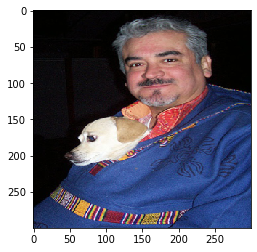

In [10]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))
plt.imshow(batch_images[i])

In [11]:
# 3: Make predictions.
# TODO: wrap in for loop for N iterations
# Results of each should be different, i.e. should get a number of different predictions (e.g. take 1 = 2 detections, take 2 = 3)
# Should be (but not always) a lot of overlap
# Need to process them - partitioning detections into observations
# Find high IOU areas

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [12]:
print(y_pred)
print(y_pred.shape)

[[[9.6036798e-01 1.1410727e-03 9.8129152e-04 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]
  [9.7408742e-01 1.4542995e-03 4.3590163e-04 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]
  [9.5394003e-01 1.4470585e-03 4.4104180e-04 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]
  ...
  [1.0279891e-02 1.6173539e-07 1.7946329e-06 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]
  [9.8532125e-02 4.2647741e-07 8.7932676e-06 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]
  [8.1188500e-02 2.9184275e-07 1.0608791e-06 ... 1.0000000e-01
   2.0000000e-01 2.0000000e-01]]]
(1, 8732, 33)


In [13]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque `apply_inverse_transforms()` function below, in this simple case it just aplies `(* original_image_size / resized_image_size)` to the box coordinates.

In [14]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 12.     0.51  38.   245.   210.   379.  ]
 [ 15.     0.93   6.    16.   356.   482.  ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

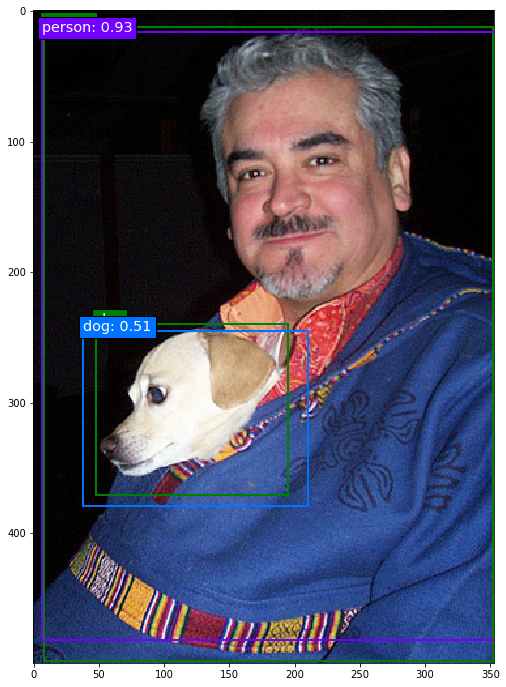

In [15]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
model.summary()